Versuch 4

*1. Fourieranalyse lang andauernder Signale*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
from scipy.signal import gausspulse
from scipy.signal.windows import gaussian
import os

running
Data saved as spracheingabe1.npy


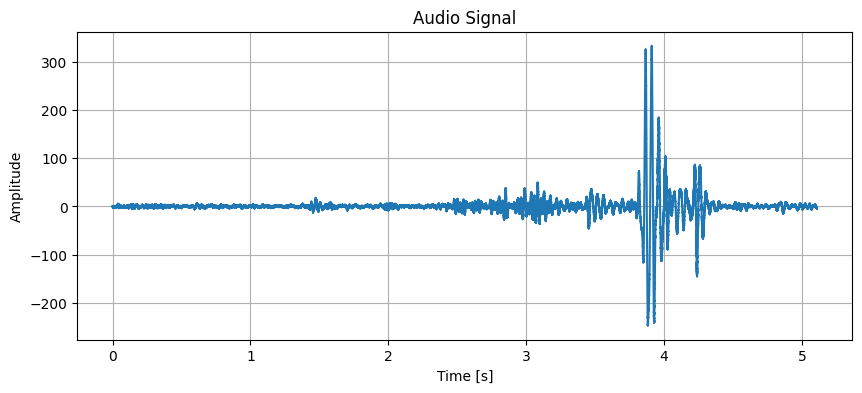

In [6]:
# Audio recording parameters
FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220

# Initialize PyAudio
p = pyaudio.PyAudio()
print('running')

# Open stream
stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ,
                input=True, frames_per_buffer=FRAMESIZE)

# Read audio data
data = stream.read(NOFFRAMES * FRAMESIZE)
decoded = np.frombuffer(data, dtype=np.int16)

# Close stream
stream.stop_stream()
stream.close()
p.terminate()

# Generate a unique filename
filename = "spracheingabe1.npy"
np.save(filename, decoded)
print(f'Data saved as {filename}')

# Plotting the audio data
time_axis = np.linspace(0, len(decoded) / SAMPLEFREQ, num=len(decoded))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, decoded)
plt.title('Audio Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


*Zuschnitt des Signals ab dem Triggerzeitounkt und Darstellung des Audiosignals und Amplitudenspektrum*

Trimmed data saved as spracheingabe1_trimmed.npy


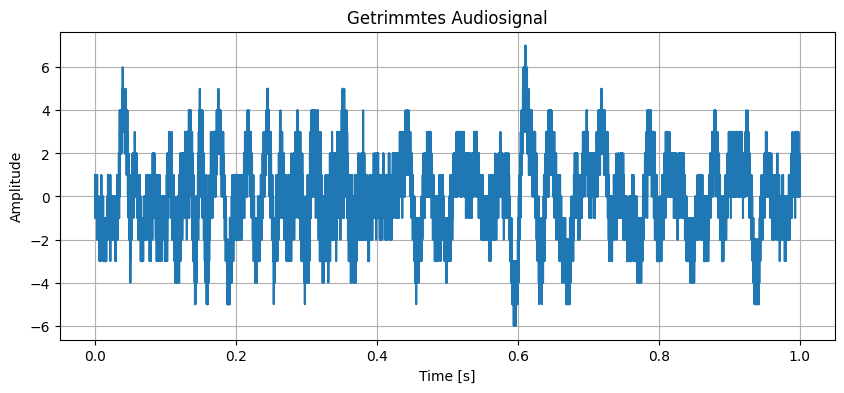

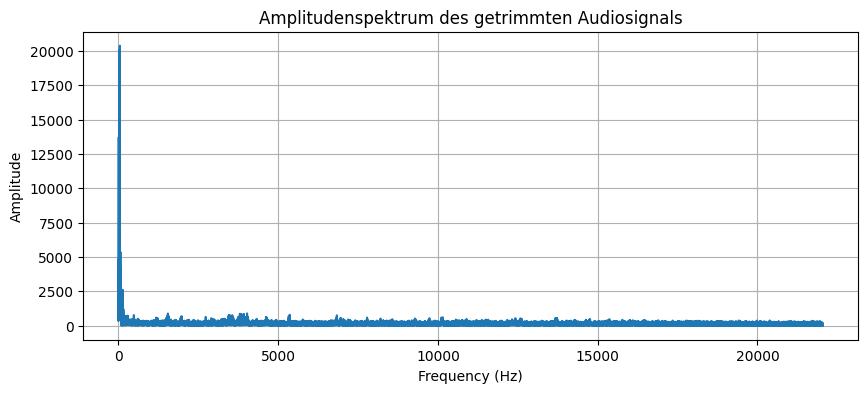

In [7]:
# Triggerfunktion, Index des ersten Wertes finden, der über dem Schwellenwert liegt
def find_trigger_point(audio_data, threshold=500):
    for i in range(len(audio_data)):
        if abs(audio_data[i]) > threshold:
            return i                    #Wert , der Schwelle überschreitet
    return 0

#Funktion, um Signal zum Triggerzeitpunkt abzuschneiden (1 Sekunde lang)
def trim_signal(audio_data, trigger_point, sample_rate=44100):
    end_point = trigger_point + sample_rate       #Triggerpunkt + Abtastrate  
    trimmed_signal = audio_data[trigger_point:end_point]
    #Länge des Signals überprüfen
    if len(trimmed_signal) < sample_rate:
        trimmed_signal = np.pad(trimmed_signal, (0, sample_rate - len(trimmed_signal)), 'constant') #mit 0-len füllen 
    return trimmed_signal

#Funktionsaufruf 
trigger_point = find_trigger_point(decoded, threshold=500)
trimmed_audio = trim_signal(decoded, trigger_point, sample_rate=SAMPLEFREQ)

#File speichern
trimmed_filename = "spracheingabe1_trimmed.npy"
np.save(trimmed_filename, trimmed_audio)
print(f'Trimmed data saved as {trimmed_filename}')

# Plot trimmed audio signal
time_axis_trimmed = np.linspace(0, len(trimmed_audio) / SAMPLEFREQ, num=len(trimmed_audio)) 

plt.figure(figsize=(10, 4))
plt.plot(time_axis_trimmed, trimmed_audio)
plt.title('Getrimmtes Audiosignal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Plotting Amplitudenspektrum
N = len(trimmed_audio)
fft_result = np.fft.fft(trimmed_audio)
magnitude_spectrum = np.abs(fft_result)
frequency_axis = np.fft.fftfreq(N, 1.0 / SAMPLEFREQ)

plt.figure(figsize=(10, 4))
plt.plot(frequency_axis[:N//2], magnitude_spectrum[:N//2])
plt.title('Amplitudenspektrum des getrimmten Audiosignals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

*Windowing Methode und Darstellung des Amplitudenspektrums*

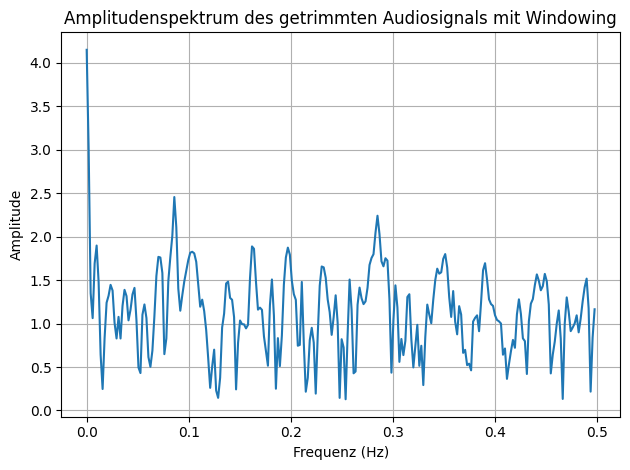

In [8]:
# Funktion zur Anwendung des Windowing und Berechnung des Amplitudenspektrums
def windowing(signal, window_length=512, overlap=0.5):
    # Berechnung der Anzahl der Fenster
    step = int(window_length * (1 - overlap))
    num_windows = (len(signal) - window_length) // step + 1
    
    std_dev = window_length / 8  # Fensterbreite = 4 * std_dev für jedes Fenster
    window = gaussian(window_length, std_dev) #Gaußsche Fensterfunktion 
    
    # Initialisierung für gemittelte Fouriertransformierte
    avg_fft = np.zeros(window_length, dtype=np.complex128)
    
    # Anwenden des Windowing und Durchführung der lokalen Fouriertransformation für jedes Fenster
    for i in range(num_windows):
        start = i * step
        end = start + window_length
        #aktuelle Fenster
        segment = signal[start:end] * window  # Fensterfunktion anwenden 
        segment_fft = np.fft.fft(segment) #Fouriertransforamtion 
        avg_fft += segment_fft #zum Durchschnitt hinzufügen
    
    # Mittelung der Fouriertransformierten
    avg_fft /= num_windows
    
    # Berechnung des Amplitudenspektrums
    amplitude_spectrum = np.abs(avg_fft)[:window_length//2] # Amplituden der Frequenzkomponenten aus der gemittelten Fouriertransformierten
    frequency_axis = np.fft.fftfreq(window_length, d=1.0)[:window_length//2] #Achse 
    
    return frequency_axis, amplitude_spectrum

# Laden des bereits getrimmten Audiosignals
trimmed_filename = "spracheingabe1_trimmed.npy"
trimmed_audio = np.load(trimmed_filename)

# Anwenden des Windowing und Berechnung des Amplitudenspektrums
frequency_axis_windowed, amplitude_spectrum_windowed = windowing(trimmed_audio, window_length=512, overlap=0.5)


# Plot des Amplitudenspektrums mit und ohne Windowing zur Überprüfung
plt.plot(frequency_axis_windowed, amplitude_spectrum_windowed)
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitudenspektrum des getrimmten Audiosignals mit Windowing')
plt.grid(True)

plt.tight_layout()
plt.show()


*Vergleich von Windowing und nach Windowing*
- vor Windowing: klare, scharfe Peaks
- nach Windowing hat man eine geglättete Darstellung der Spektralkomponenten (-> Einfluss der Gaußsche Fensterfunktion)

2. Spracherkennung

*Referenzspektren berechnen*

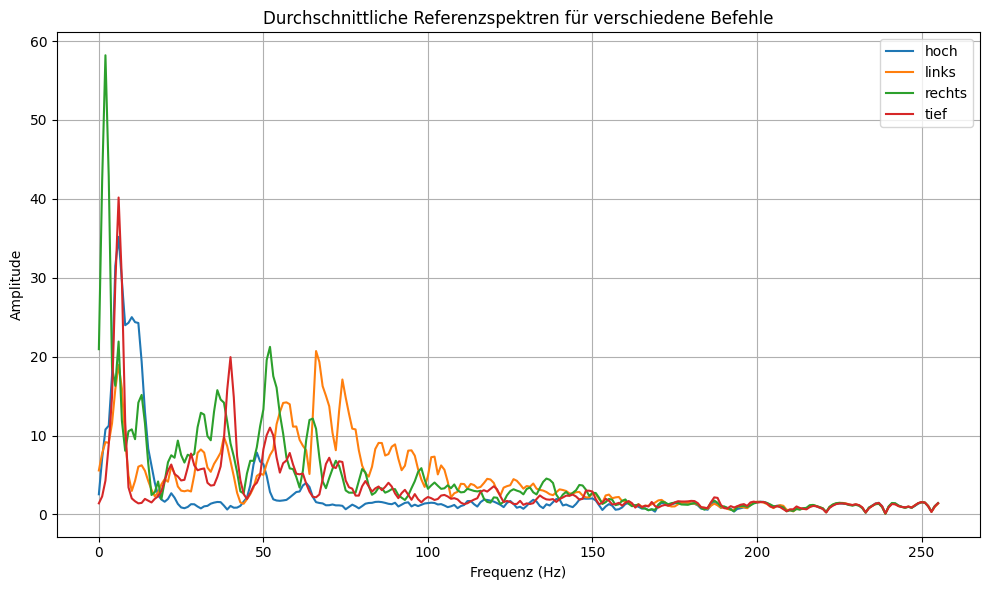

In [57]:
# Hauptteil des Codes
directory_path = "C:/Users/ellen/OneDrive/Documents/Studium/Semester3/sss/Versuche/SSS/versuch4/Ellen"
commands = ["hoch", "links", "rechts", "tief"]
bsp_pro_command = 5  # Anzahl der Beispiele pro Befehl

ref_specs = {} # Dictionary zur Speicherung der Referenzspektren

# Schleife über alle Befehle
for command in commands:
    spec = []
    for i in range(1, bsp_pro_command + 1):
        filename = os.path.join(directory_path, f"{command}{i}.npy")  # Dateiname basierend auf dem Befehl und Index
        
        if not os.path.exists(filename):
            print(f"Datei {filename} existiert nicht!")
            continue
        
        try:
            audio = np.load(filename, allow_pickle=True)  # Laden der Audiodaten mit Pickle-Erlaubnis
        except Exception as e:
            print(f"Fehler beim Laden von {filename}: {e}")
            continue

        # Überprüfen, ob das geladene Audio-Signal die erwartete Form hat
        if not isinstance(audio, np.ndarray):
            print(f"Unerwarteter Datentyp in {filename}: {type(audio)}")
            continue

        if audio.ndim != 1:
            print(f"Unerwartete Form der Audiodaten in {filename}: {audio.shape}")
            continue

        frequency_axis, reference_spectrum = windowing(audio, window_length=512, overlap=0.5)  # Windowing-Methode anwenden
        spec.append(reference_spectrum)  # Referenzspektrum hinzufügen

    if not spec:
        print(f"Keine gültigen Daten für den Befehl '{command}' gefunden.")
        continue

    # Speichern der Spektren für jeden Befehl im Dictionary
    ref_specs[command] = spec

# Berechnung der Mittelwerte für jeden Befehl
mean_specs = {}

for command, spectra in ref_specs.items():
    mean_spec = np.mean(spectra, axis=0)
    mean_specs[command] = mean_spec

# Plotten der durchschnittlichen Spektren für jeden Befehl
plt.figure(figsize=(10, 6))

for command, mean_spec in mean_specs.items():
    plt.plot(mean_spec, label=command)

plt.xlabel("Frequenz (Hz)")
plt.ylabel("Amplitude")
plt.title("Durchschnittliche Referenzspektren für verschiedene Befehle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


*Bravais-Pearson Korrelationskoeffizienten Berechnung*

In [63]:
directory_path = "C:/Users/ellen/OneDrive/Documents/Studium/Semester3/sss/Versuche/SSS/versuch4/Ellen"
commands = ["hoch", "links", "rechts", "tief"]
bsp_pro_command = 5  # Anzahl der Beispiele pro Befehl

# Schleife über alle Befehle
for command in commands:
    for i in range(1, bsp_pro_command + 1):
        filename = os.path.join(directory_path, f"{command}{i}.npy")  # Dateiname basierend auf dem Befehl und Index

hoch = "hoch1.npy"
tief = "tief1.npy"
rechts = "rechts1.npy"
links = "links1.npy"

#Korrelationskoeffizienten berechnen nach Pearson
def pearson_correlation(x, y):
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    x_deviation = x - mean_x
    y_deviation = y - mean_y
    covariance = np.sum(x_deviation * y_deviation) / len(x)
    std_x = np.std(x)
    std_y = np.std(y)

    corr = covariance / (std_x * std_y)

    return corr

#Korrelationsberechnung testen
_, test_spectrum_hoch = windowing(hoch, window_length=512, overlap=0.5)
test_spectrum_tief = windowing(tief, window_length=512, overlap=0.5)
test_spectrum_rechts = windowing(rechts, window_length=512, overlap=0.5)
test_spectrum_links = windowing(links, window_length=512, overlap=0.5)
print(test_spectrum_hoch)
print("xx")
print(ref_specs["hoch"])

# Überprüfung, ob alle Referenzspektren definiert sind
for command in commands:
    if command not in ref_specs:
        print(f"Referenzspektrum für Befehl '{command}' nicht definiert.")
    else:
        cor = pearson_correlation(test_spectrum_hoch, ref_specs[command])
        print(f"Korrelation {command}: {cor}")

def vergleich(test_spectrum_hoch, test_spectrum_links, test_spectrum_rechts, test_spectrum_tief, ref_specs):
    if "hoch" in ref_specs and "hoch" in ref_specs:
        corr_hh = pearson_correlation(test_spectrum_hoch, test_spectrum_hoch)
        print(f"Korrelation hoch vs hoch: {corr_hh}")

    if "hoch" in ref_specs and "tief" in ref_specs:
        corr_ht = pearson_correlation(test_spectrum_hoch, test_spectrum_tief)
        print(f"Korrelation hoch vs tief: {corr_ht}")

    if "hoch" in ref_specs and "links" in ref_specs:
        corr_hl = pearson_correlation(test_spectrum_hoch, test_spectrum_links)
        print(f"Korrelation hoch vs links: {corr_hl}")

    if "hoch" in ref_specs and "rechts" in ref_specs:
        corr_hr = pearson_correlation(test_spectrum_hoch, test_spectrum_rechts)
        print(f"Korrelation hoch vs rechts: {corr_hr}")
    
    return max(corr_hh, corr_hl, corr_hr, corr_ht)

vergleich(test_spectrum_hoch, test_spectrum_links, test_spectrum_rechts, test_spectrum_tief, ref_specs)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
xx
[array([3.16932316e+00, 6.85390376e+00, 1.06537030e+01, 1.16068339e+01,
       1.33859430e+01, 1.80946084e+01, 1.77924765e+01, 5.22659975e+00,
       9.81489219e+00, 1.12058868e+01, 5.22333181e+00, 3.11586039e+00,
   

C:\Users\ellen\AppData\Local\Temp\ipykernel_16136\1466970296.py:26: RuntimeWarning: invalid value encountered in scalar divide
  corr = covariance / (std_x * std_y)


nan

*Spracherkenner implementieren*
- *Detektions und Fehlerrate ausgeben*

In [29]:
def spracherkenner(spektrum, ref_specs):
    referenz_spektren = {
        "hoch": ref_specs["hoch"],
        "tief": ref_specs["tief"],
        "links": ref_specs["links"],
        "rechts": ref_specs["rechts"]
    }
    max_corr = 0
    predicted_command = None

    for command, ref_spec in referenz_spektren.items():
        temp_corr = pearson_correlation(spektrum, ref_spec)
        if temp_corr > max_corr:
            max_corr = temp_corr
    return predicted_command

# Testdaten laden
test_directory = "C:/Users/ellen/OneDrive/Documents/Studium/Semester3/sss/Versuche/SSS/versuch4/Ellen"
test_files = os.listdir(test_directory)

# Zähler für korrekte und falsche Klassifizierungen
correct_count = 0
incorrect_count = 0

for test_file in test_files:
    test_path = os.path.join(test_directory, test_file)
    test_audio = np.load(test_path, allow_pickle=True)
    
    # Amplitudenspektrum der Testdatei berechnen
    _, test_spectrum = windowing(test_audio, window_length=512, overlap=0.5)
    
    # Klassifizierung mit dem Spracherkenner
    predicted_command = spracherkenner(test_spectrum, ref_specs)
    
    # Zählen der korrekten und falschen Klassifizierungen
    expected_command = test_file.split("_")[0]
    if predicted_command == expected_command:
        correct_count += 1
    else:
        incorrect_count += 1

# Berechnung der Detektions- und Fehlerrate
total_count = correct_count + incorrect_count
detection_rate = correct_count / total_count * 100
error_rate = incorrect_count / total_count * 100

print(f"Detektionsrate: {detection_rate:.2f}%")
print(f"Fehlerrate: {error_rate:.2f}%")

Detektionsrate: 0.00%
Fehlerrate: 100.00%
